### `Dependencies`

Requirements

In [819]:
#pip install -r requirements.txt

Utilities

In [820]:
import os
import time
import nbformat
import json

Data Science Librarys

In [821]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

ML Libraries

In [822]:
from sklearn.preprocessing import (
    # Numerical features
    StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler,
    KBinsDiscretizer, Binarizer,
    QuantileTransformer, PowerTransformer,
    PolynomialFeatures,
    # Categorical features 
    OrdinalEncoder, OneHotEncoder, TargetEncoder
)

from sklearn.feature_selection import (
    VarianceThreshold,
    SelectKBest,
    SelectPercentile,
    SequentialFeatureSelector,
    f_classif,
    f_regression,
)

from sklearn.compose import ColumnTransformer

from sklearn.pipeline import make_pipeline

from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV, 
    LearningCurveDisplay, ValidationCurveDisplay
)

from sklearn.metrics import (
classification_report, ConfusionMatrixDisplay
)

from sklearn.linear_model import Ridge, LogisticRegression

from sklearn.svm import SVC, SVR

from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

from sklearn.ensemble import (
    RandomForestClassifier, RandomForestRegressor,
    GradientBoostingClassifier, GradientBoostingRegressor
)

# xgboost
from xgboost import XGBClassifier, XGBRegressor

### `Config`

Task

In [823]:
task = "Classification"

Estimator

In [824]:
estimator = RandomForestClassifier(n_jobs=-1)

In [825]:
estimator_grid = {
    "randomforestclassifier__n_estimators": [500, 1000, 3000],
    "randomforestclassifier__max_depth": [5, 10, 15, 20]
}

Metric

In [826]:
primary_metric = "recall"

Preprocessors

In [827]:
# Scaler
scaler = MinMaxScaler()
scaler_cols = []

# Discretizer
discretizer = None
distribution_transformer = QuantileTransformer(
    n_quantiles=20,
    output_distribution="normal",
    random_state=42
)
polynomials = PolynomialFeatures(degree=2)

# Categorical columns
ordinal_encoder = None
one_hot_encoder = OneHotEncoder()
target_encoder = TargetEncoder()

Validation

In [828]:
learning_curve = True

### `Utils`

In [829]:
%run src/utils.ipynb

### `Data Ingestion`

In [830]:
# Load data
path = "/Users/mlprof/Documents/GitHub/machine-learning-ready/04 ML Pipelines/Titanic/"

data = pd.read_csv(f"{path}train.csv")
submission = pd.read_csv(f"{path}test.csv")

In [831]:
display(data.info())
display(submission.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


None

In [832]:
display(data.head(3))
display(submission.head(3))

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q


In [833]:
display(data.describe())

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### `Data Pre-Processing`

##### `Data Engineering`

In [834]:
# Drop cols with NaN in train and test set
cols_to_drop = ["Name", "Fare", "Ticket", "Cabin"]

data = data.drop(columns=cols_to_drop)
submission = submission.drop(columns=cols_to_drop)

In [835]:
# Drop remaining rows with NaN in train set
data = data.dropna(subset=["Age", "Embarked"])

In [836]:
# Define X and y
X = data.drop(columns=["PassengerId", "Survived"])
y = data.loc[:, "Survived"]

In [837]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42
)

##### `Feature Engineering`

In [838]:
preprocessor = ColumnTransformer(
    transformers=[], 
    remainder="passthrough"
)

In [839]:
categorical_cols = X_train.select_dtypes(
    include=["object", "category"]
).columns.tolist()

numerical_cols = X_train.select_dtypes(
    include=["int64", "float64"]
).columns.tolist()

print(f"Categorical Columns: {categorical_cols}")
print(f"Numerical Columns: {numerical_cols}")

Categorical Columns: ['Sex', 'Embarked']
Numerical Columns: ['Pclass', 'Age', 'SibSp', 'Parch']


for `Classifiers`:

In [840]:
if isinstance(estimator, (LogisticRegression, SVC, KNeighborsClassifier)):

    # ----------------------------------------
    # Numerical columns
    # ----------------------------------------

    # Polynomials
    if polynomials is not None:
        preprocessor.transformers.append(
            (str(polynomials).replace("()", "").lower(), polynomials, numerical_cols)
        )

    # Scaler
    if scaler is not None:
        preprocessor.transformers.append(
            (str(scaler).replace("()", "").lower(), scaler, numerical_cols)
        )

    # Mapping to Gaussian
    if distribution_transformer is not None:
        preprocessor.transformers.append(
            (
                str(distribution_transformer).replace("()", "").lower(),
                distribution_transformer,
                numerical_cols,
            )
        )

    # Discretizer

    # ----------------------------------------
    # Categorical columns
    # ----------------------------------------

    # One Hot Encoder
    if one_hot_encoder is not None:
        preprocessor.transformers.append(
            (
                str(one_hot_encoder).replace("()", "").lower(),
                one_hot_encoder,
                categorical_cols,
            )
        )

elif isinstance(
    estimator, (RandomForestClassifier, GradientBoostingClassifier, XGBClassifier)
):

    # ----------------------------------------
    # Numerical columns
    # ----------------------------------------

    # ...
    # Mapping to Gaussian
    if distribution_transformer is not None:
        preprocessor.transformers.append(
            (
                str(distribution_transformer).replace("()", "").lower(),
                distribution_transformer,
                numerical_cols,
            )
        )

    # ----------------------------------------
    # Categorical columns
    # ----------------------------------------

    # Target Encoder
    if target_encoder is not None:
        preprocessor.transformers.append(
            (
                str(target_encoder).replace("()", "").lower(),
                target_encoder,
                categorical_cols,
            )
        )

for `Regressors`:

In [841]:
if isinstance(estimator, (Ridge, SVR, KNeighborsRegressor)):

    # ----------------------------------------
    # Numerical columns
    # ----------------------------------------

    # Polynomials
    if polynomials is not None:
        preprocessor.transformers.append(
            (str(polynomials).replace("()", "").lower(), polynomials, numerical_cols)
        )

    # Scaler
    if scaler is not None:
        preprocessor.transformers.append(
            (str(scaler).replace("()", "").lower(), scaler, numerical_cols)
        )

    # Mapping to Gaussian
    if distribution_transformer is not None:
        preprocessor.transformers.append(
            (
                str(distribution_transformer).replace("()", "").lower(),
                distribution_transformer,
                numerical_cols,
            )
        )

    # ----------------------------------------
    # Categorical columns
    # ----------------------------------------

    # One Hot Encoder
    if one_hot_encoder is not None:
        preprocessor.transformers.append(
            (
                str(one_hot_encoder).replace("()", "").lower(),
                one_hot_encoder,
                categorical_cols,
            )
        )

### `Data Modeling`

Pipeline

In [842]:
pipeline = make_pipeline(preprocessor, estimator)

Parameter Grid

In [843]:
# Define transformer params
param_grid = {}

# Add custom estimator params
param_grid.update(estimator_grid)

display(param_grid)

{'randomforestclassifier__n_estimators': [500, 1000, 3000],
 'randomforestclassifier__max_depth': [5, 10, 15, 20]}

Evaluation Metrics

In [844]:
# ----------------------------------------
# Classification
# ----------------------------------------

if task == "Classification":
    metrics = ["precision", "recall"]

    if primary_metric not in metrics:
        message = f""" 
        Error: "{primary_metric}" is not a valid metric for {task} tasks.
        Valid metrics are: {metrics}
        """
        raise Exception(message)
    else:
        pass

# ----------------------------------------
# Regression
# ----------------------------------------


GridSearch

In [845]:
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring=metrics,
    refit=primary_metric,
    return_train_score=True,
    n_jobs=-1,
)

Training

In [846]:
grid.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('quantiletransformer(n_quantiles=20, '
                                                                         "output_distribution='normal',\n"
                                                                         '                    '
                                                                         'random_state=42)',
                                                                         QuantileTransformer(n_quantiles=20,
                                                                                             output_distribution='normal',
                                                                                             random_state=42),
                                                                         ['Pclass',
                                                                          'Age',
                                                                          'SibSp',
                                                                          'Parch']),
                                                                        ('targetencoder',
                                                                         TargetEncoder(),
                                                                         ['Sex',
                                                                          'Embarked'])])),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': [5, 10, 15, 20],
                         'randomforestclassifier__n_estimators': [500, 1000,
                                                                  3000]},
             refit='recall', return_train_score=True,
             scoring=['precision', 'recall'])

### `Model Evaluation`

Best Estimator

In [847]:
print("Best parameters (CV Score=%0.3f):" % grid.best_score_, grid.best_params_)

Best parameters (CV Score=0.717): {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__n_estimators': 3000}


In [848]:
display(grid.best_estimator_)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('quantiletransformer(n_quantiles=20, '
                                                  "output_distribution='normal',\n"
                                                  '                    '
                                                  'random_state=42)',
                                                  QuantileTransformer(n_quantiles=20,
                                                                      output_distribution='normal',
                                                                      random_state=42),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch']),
                                                 ('targetencoder',
                                                  TargetEncoder(),
                                                  ['Sex', 'Embarked'])])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=20, n_estimators=3000,
                                        n_jobs=-1))])

##### `Evaluation on Training Data`

CV Results

In [849]:
cv_results = pd.DataFrame(grid.cv_results_)
display(cv_results.sort_values(by=f"rank_test_{primary_metric}"))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__max_depth,param_randomforestclassifier__n_estimators,params,split0_test_precision,split1_test_precision,split2_test_precision,...,split1_test_recall,split2_test_recall,mean_test_recall,std_test_recall,rank_test_recall,split0_train_recall,split1_train_recall,split2_train_recall,mean_train_recall,std_train_recall
11,3.843488,0.287802,0.260695,0.004599,20,3000,"{'randomforestclassifier__max_depth': 20, 'ran...",0.663265,0.846154,0.885246,...,0.767442,0.627907,0.717054,0.063215,1,0.895349,0.808140,0.796512,0.833333,0.044108
8,4.810877,0.496140,0.331681,0.015500,15,3000,"{'randomforestclassifier__max_depth': 15, 'ran...",0.660000,0.769231,0.863636,...,0.697674,0.662791,0.709302,0.043508,2,0.872093,0.825581,0.808140,0.835271,0.026993
9,0.819729,0.151453,0.052254,0.007896,20,500,"{'randomforestclassifier__max_depth': 20, 'ran...",0.700000,0.783784,0.802632,...,0.674419,0.709302,0.705426,0.023893,3,0.819767,0.796512,0.848837,0.821705,0.021406
3,0.761705,0.016018,0.078824,0.031572,10,500,"{'randomforestclassifier__max_depth': 10, 'ran...",0.687500,0.865672,0.876923,...,0.674419,0.662791,0.701550,0.046834,4,0.866279,0.767442,0.796512,0.810078,0.041475
6,0.835353,0.229794,0.052736,0.005971,15,500,"{'randomforestclassifier__max_depth': 15, 'ran...",0.707865,0.787500,0.868852,...,0.732558,0.616279,0.693798,0.054814,5,0.831395,0.843023,0.819767,0.831395,0.009494
7,1.666254,0.202268,0.112623,0.030743,15,1000,"{'randomforestclassifier__max_depth': 15, 'ran...",0.680851,0.791667,0.852941,...,0.662791,0.674419,0.693798,0.035944,6,0.843023,0.796512,0.819767,0.819767,0.018988
5,5.115959,0.213094,0.366768,0.049429,10,3000,"{'randomforestclassifier__max_depth': 10, 'ran...",0.772152,0.830986,0.888889,...,0.686047,0.651163,0.682171,0.023893,7,0.738372,0.796512,0.773256,0.769380,0.023893
4,1.762597,0.046965,0.086186,0.002498,10,1000,"{'randomforestclassifier__max_depth': 10, 'ran...",0.681319,0.842857,0.881356,...,0.686047,0.604651,0.670543,0.048720,8,0.860465,0.767442,0.744186,0.790698,0.050238
10,1.382174,0.085566,0.075700,0.004268,20,1000,"{'randomforestclassifier__max_depth': 20, 'ran...",0.705882,0.816901,0.900000,...,0.674419,0.627907,0.666667,0.029005,9,0.796512,0.790698,0.784884,0.790698,0.004747
2,4.348010,0.090352,0.327294,0.050590,5,3000,"{'randomforestclassifier__max_depth': 5, 'rand...",0.752941,0.888889,0.925926,...,0.651163,0.581395,0.658915,0.066685,10,0.755814,0.691860,0.668605,0.705426,0.036873


Learning Curve

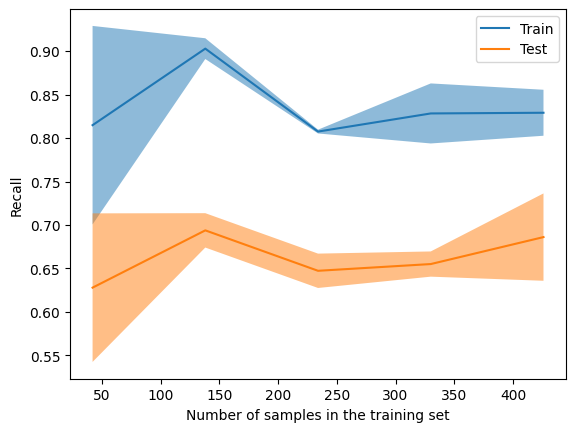

In [850]:
if learning_curve==True:
    
    LearningCurveDisplay.from_estimator(
        estimator=grid.best_estimator_, 
        X=X_train, 
        y=y_train,
        train_sizes=np.linspace(0.1, 1.0, 5), 
        cv=3, 
        scoring=primary_metric
    )

plt.show()

Validation Curves


In [851]:
# ...

##### `Evaluation on Test Data`

Classification Report

In [852]:
if task == "Classification":
    print(classification_report(y_test, grid.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      0.90      0.85        42
           1       0.84      0.70      0.76        30

    accuracy                           0.82        72
   macro avg       0.82      0.80      0.81        72
weighted avg       0.82      0.82      0.82        72



Confusion Matrix

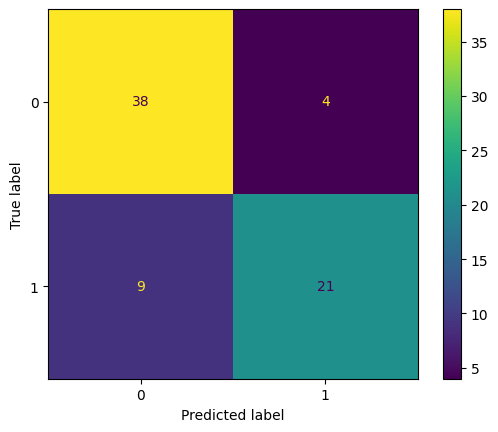

In [853]:
if task == "Classification":
    ConfusionMatrixDisplay.from_estimator(grid.best_estimator_, X_test, y_test)

### `Model Tracking`

In [10]:
%pip install mlflow

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 24.1.2
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
import mlflow

/Users/mlprof/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [21]:
mlflow server --host 127.0.0.1 --port 8080

SyntaxError: invalid syntax (436093207.py, line 1)